# An upper bound for the sojourn time cdf in a Markovian processor sharing R-server Join-Shortest-Queue system

### The system
+ There are $R$ parallel processor sharing servers.
+ Customers arrive according to a Poisson distribution with rate $\Lambda$.
+ Upon arrival customers are routed to the server with the least amount of customers.
+ Intended service times are Exponenially distributed with rate $\mu$.

### What we know
+ We can define a Markov chain of the system explicitly:
  + States of the markov chain take the form $(a_1, a_2, ..., a_R)$, where $a_k$ is the number of customers being served by server $k$;
  + This can be solved to give $p(j)$, the probability of being in state $j$, for all $j$.
  + This is computed numerically by choosing a sufficiently large cut-off limit, $l$ such that no more customers are admitted to any server with $l$ customers.
  + States can be aggregated any way we like.
+ From *(Masuyama, H. and Takine, T., 2003. Sojourn time distribution in a MAP/M/1 processor-sharing queue. Operations Research Letters, 31(5), pp.406-412)* we know $P(S>t|n)$ for an M/M/1-PS queue; the probability that the sojourn time $S$ is greater than some number $t$, conditional on the number of customers already at queue upon arrival, $n$.
  + This can be computed numerically by choosing an arbitrary large number instead of infinity.

### General idea
Consider a customer arriving to our JSQ system:
+ From the Markov chain, we know the probability that they will arrive while the system is in state $j$ is $p(j)$.
+ Each state $j$ can be transformed into an $n$. Customers are always routed to the server with the least servers, so $n = \min(j)$.
+ Now the arriving customer is essentially arriving to an M/M/1-PS system in state $n$:
  + It has the same intended service times with mean $\mu$.
  + However it now has state-dependant arrivals. When in state $n$ is receives all customers if the other servers have more customers than it (rate $\Lambda$); $1/c$ of the customers if there are $c$ servers with the same number of customers as it and all others have more than it (rate $\Lambda/c$; and it no customers if at least one other server has more customers than it (rate $0$). Together then, this has rate $\lambda_n = \pi_n \Lambda$ where $\pi_n$ is a proportion that can be found from $p(j)$.
  + In order to find the sojourn time cdf, we need a constant arrival rate. So can we find an upper bound for $\lambda_n$?
  + Yes. $\lambda_0 > \lambda_n$ for all $n$. Why? Well if $n=0$ then there is a good chance that the server being considered is the minimum and so $\pi_0$ would be quite high. As $n$ increases, there is more chance that one of the other parallel servers is in fact the minimum and so $\pi_n$ will decrease.
  + So as an upper bound, we can say that this M/M/1-PS server has arrivals at most $\pi_0 \Lambda$, which can be used in the sojourn time cdf calculations.
  + This corresponds to an upper bound, because in processor sharing systems, the higher the arrival rate, the more customers entering the node, the slower the service rate, the longer the sojourn time.
+ Therefore we can find an upper bound for the sojourn time cdf for a customer arriving in state some state $j$, $P(S>t|j)$ (as $j$ can be transformed to $n$. We also know the probability of being in state $j$. So $P(S > t) = \sum_j P(S>t|j)p(j)$.

In [1]:
import ciw
import sojourn_times.sojourn as sj
import markov_chain.models as mc
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
plt.style.use('seaborn-whitegrid')

## Define the parameters

In [2]:
# Parameters
lambda_ = 10
mu = 12
R = 3

# Hyperparameters
max_time = 50000
warmup = 200
mc_limit = 12
infty = 130

## Begin with simulation for verification as we go

In [3]:
class RoutingDecision(ciw.Node):
    def next_node(self, ind):
        """
        Finds the next node by looking at the other nodes,
        seeing how busy they are, and routing to the least busy.
        """
        busyness = {n: self.simulation.nodes[n].number_of_individuals for n in range(2, self.simulation.network.number_of_nodes + 1)}
        chosen_n = sorted(busyness.keys(), key=lambda x: busyness[x])[0]
        return self.simulation.nodes[chosen_n]

In [4]:
N = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(lambda_)] + [ciw.dists.NoArrivals() for _ in range(R)],
    service_distributions=[ciw.dists.Deterministic(0)] + [ciw.dists.Exponential(mu) for _ in range(R)],
    number_of_servers=[float('inf') for _ in range(R + 1)],
    routing=[[0 for row in range(R + 1)] for col in range(R + 1)]
)

In [5]:
ciw.seed(0)
Q = ciw.Simulation(N, node_class=[RoutingDecision] + [ciw.PSNode for _ in range(R)])
Q.simulate_until_max_time(max_time, progress_bar=True)
recs = Q.get_all_records()
recs = [r for r in recs if r.arrival_date > warmup and r.arrival_date < max_time - warmup and r.node != 1]

100%|██████████| 50000.0/50000 [00:27<00:00, 1850.75it/s]           


## Use the Markov Chain method to get $p(j)$

In [6]:
M = mc.MMkPS(L=lambda_, m=mu, k=R, limit=mc_limit)
M.solve()

## Convert these states to 'number of customers in queue upon arrival' (n)
+ Customers arrive to the least busy server
+ Aggregating over all $j$ that correspond to the same $n$

In [7]:
n_probs = {}
for state in M.probs.keys():
    n = min(state)
    if n in n_probs:
        n_probs[n] += M.probs[state]
    else:
        n_probs[n] = M.probs[state]

+ Check that the markov chain is computing $p(n)$ correctly, plot agaisnt simulation for verification

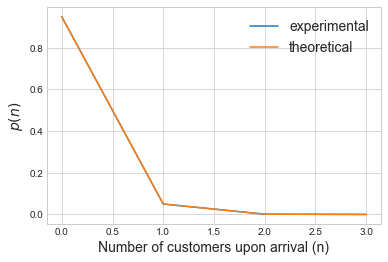

In [8]:
from collections import Counter
sizes = [r.queue_size_at_arrival for r in recs]
biggest_n = max(sizes)
fig, ax = plt.subplots(1)
ax.plot(range(biggest_n), [Counter(sizes)[n] / len(sizes) for n in range(biggest_n)], label='experimental')
ax.plot(range(biggest_n), [n_probs[n] for n in range(biggest_n)], label='theoretical')
ax.legend(fontsize=14)
ax.set_xlabel('Number of customers upon arrival (n)', fontsize=14)
ax.set_ylabel("$p(n)$", fontsize=14)
plt.show()

## Calculating $\pi_0$
+ First calculate $\pi_n$ for all $n$, that is, how much 'share' of the overall arrival rate does each $n$ receive?
+ e.g. when n=0 there is a good chance that that server is the minimum server, and so will more than 1/3rd chance of the that sever getting the arrival.
+ e.g. when n=10 there is a good chance that the other servers contain the minumum, and so less chance that this server will get the arrival.

In [9]:
ns = []
pns = []
props = []
for n in range(mc_limit):
    ns.append(n)
    pn = 0
    pnarr = 0
    for state in M.probs:
        if n in state:
            pn += M.probs[state]
            if min(state) == n and state[0] == n:
                c = state.count(n)
                pnarr += M.probs[state] / c
    pns.append(pn)
    props.append(pnarr / pn)

+ Plot to see is $\pi_0$ is indeed the largest.

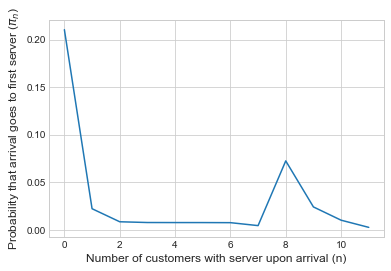

In [10]:
fig, ax = plt.subplots(1)
ax.plot(ns, props)
ax.set_xlabel("Number of customers with server upon arrival (n)", fontsize=12)
ax.set_ylabel("Probability that arrival goes to first server ($\pi_n$)", fontsize=12)
plt.show()

In [11]:
max_share = props[0]
max_share

0.21035204870737662

# Calcuate W(n)
+ Calculate $W(t, n)$ the sojourn time cdf for each $n$
+ Plot against simulation for verification

In [12]:
times = np.linspace(0, 1.25, 50)

In [13]:
S = sj.MM1PS(mu=mu, lambda_=lambda_ * max_share, infty=infty)

In [14]:
experimental_split = [[(100 - scipy.stats.percentileofscore([r.service_time for r in recs if r.queue_size_at_arrival == n], t, kind='strict')) / 100 for t in times] for n in range(4)]
theoretical_split = [[S.wn(t, n) for t in times] for n in range(4)]

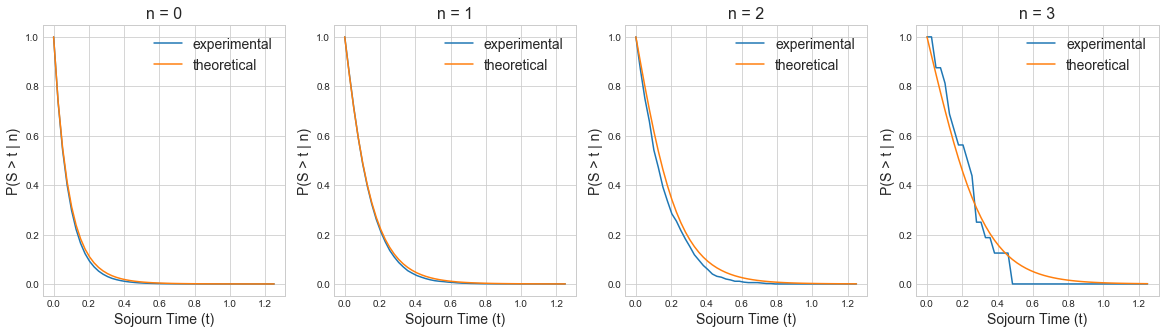

In [15]:
fig, axarr = plt.subplots(1, 4, figsize=(20, 5))
for n in range(4):
    axarr[n].plot(times, experimental_split[n], label='experimental')
    axarr[n].plot(times, theoretical_split[n], label='theoretical')
    axarr[n].legend(fontsize=14)
    axarr[n].set_title(f"n = {n}", fontsize=16)
    axarr[n].set_xlabel("Sojourn Time (t)", fontsize=14)
    axarr[n].set_ylabel("P(S > t | n)", fontsize=14)
plt.show()

+ Aggregate by multiplying each of these with $p(n)$ and summing

In [16]:
sojourn_time_cdf = [sum([S.wn(t, n) * n_probs[n] for n in n_probs.keys()]) for t in times]

In [17]:
sojourn_times = [r.service_time for r in recs]
experimental = [(100 - scipy.stats.percentileofscore(sojourn_times, t, kind='strict')) / 100 for t in times]

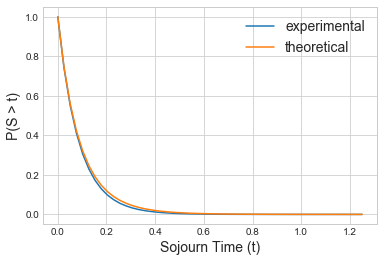

In [18]:
fig, ax = plt.subplots(1)
ax.plot(times, experimental, label='experimental')
ax.plot(times, sojourn_time_cdf, label='theoretical')
ax.legend(fontsize=14)
ax.set_xlabel("Sojourn Time (t)", fontsize=14)
ax.set_ylabel("P(S > t)", fontsize=14)
plt.show()

We can see this is pretty close, but it's still out a little.

+ Plot errors against $t$

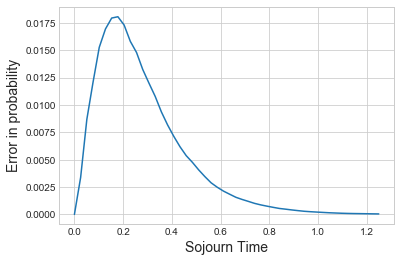

In [19]:
fig, ax = plt.subplots(1)
ax.plot(times, [t - e for t, e in zip(sojourn_time_cdf, experimental)])
ax.set_xlabel("Sojourn Time", fontsize=14)
ax.set_ylabel("Error in probability", fontsize=14)
plt.show()

+ We see this is indeed an upper bound, as no errors are negative.
+ The maximum error is around 0.0175 i.e. 1.75%, which is faily big.
+ However we see in the tails the distirbution gets much more accurate, and I think this is what's important for us?

## Limitations
+ We need to run many many more experiements with different parameters to be sure.
+ This methodology is quite inefficient, and only works for small systems, R=1, R=2 and R=3.
+ Even then we need to be careful about what parameters to use. When R=3 we cannot have a Markov chain allowing more than around 15 customers with each server, so it's limited to small values of $\rho = \Lambda / \mu$. With R=2 we can go up to around 45 customers per server.
+ The sojourn time calculation used `math.frac` on the infinity, and so we cannot use values of infinity more than 165 ish. Although this seems plenty to converge for now on these small systems.
+ Cell 10, plotting the $\pi_n$'s - I really don't know why it seems to rise again at the end. Maybe this is a result of the Markov chain cut-off limit.